# Experiment 3: Virual Adversarial Training

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

In [53]:
def calculate_accuracy(loader, model):
    
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in loader:

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


def normalize_tensor(input_tensor):
    reshaped_tensor = input_tensor.view(input_tensor.shape[0], -1, *(1 for _ in range(input_tensor.dim() - 2)))
    input_tensor /= torch.norm(reshaped_tensor, dim=1, keepdim=True) + 1e-8
    return input_tensor


class VirtualAdversarialLoss(nn.Module):

    def __init__(self, xi=10.0, epsilon=1.0, power_iterations=1):
        super(VirtualAdversarialLoss, self).__init__()
        self.xi = xi
        self.epsilon = epsilon
        self.power_iterations = power_iterations

    def forward(self, neural_net, input_data):
        with torch.no_grad():
            initial_prediction = F.softmax(neural_net(input_data), dim=1)

        # Initialize random unit tensor
        random_tensor = torch.rand(input_data.shape).sub(0.5).to(input_data.device)
        random_tensor = normalize_tensor(random_tensor)

        # Calculate adversarial direction
        for _ in range(self.power_iterations):
            random_tensor.requires_grad_()
            perturbed_prediction = neural_net(input_data + self.xi * random_tensor)
            adversarial_dist = F.kl_div(perturbed_prediction, initial_prediction, reduction='batchmean')
            adversarial_dist.backward()
            random_tensor = normalize_tensor(random_tensor.grad)
            neural_net.zero_grad()

        # Calculate Loss due to Virtual Adversarial Training
        adversarial_perturbation = random_tensor * self.epsilon
        final_prediction = neural_net(input_data + adversarial_perturbation)
        virtual_adversarial_loss = F.kl_div(final_prediction, initial_prediction, reduction='batchmean')

        return virtual_adversarial_loss
    

def trainAndPlot(model,labeled_loader, unlabeled_loader, b_alpha ,   num_epochs, readingAtEpoch, lr,xi,  epsilon, num_power_iterations):
    # Lists to store metrics
    supervised_losses = []
    unsupervised_losses = []
    train_accuracies = []
    test_accuracies = []

    
    # Variable to store the best test accuracy
    best_test_accuracy = 0.0
    best_epoch = 0

    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    vat_loss = VirtualAdversarialLoss(xi=xi, epsilon=epsilon, power_iterations=num_power_iterations)

    for epoch in range(num_epochs):

        # Train on labeled data
        for labeled_batch, unlabeled_batch in zip(labeled_loader, unlabeled_loader):
            # Unpack labeled data
            l_images, l_labels = labeled_batch
            # Unpack unlabeled data
            u_images, u_labels = unlabeled_batch
        
            
            # Forward pass for labeled data
            optimizer.zero_grad()
            l_outputs = model(l_images)
            supervised_loss = criterion(l_outputs, l_labels)

            # Compute VAT loss on unlabeled data
            lds = vat_loss(model, u_images)
      

            total_loss = supervised_loss + b_alpha* lds
            total_loss.backward()
            optimizer.step()


        if epoch%readingAtEpoch==0:

            supervised_loss_value = supervised_loss.item()
            unsupervised_loss_value = lds.item()
            train_accuracy_value = calculate_accuracy(labeled_loader, model)
            test_accuracy_value = calculate_accuracy(unlabeled_loader, model)

            if test_accuracy_value > best_test_accuracy:
                best_test_accuracy = test_accuracy_value
                best_epoch = epoch

            supervised_losses.append(supervised_loss_value)
            unsupervised_losses.append(unsupervised_loss_value)
            train_accuracies.append(train_accuracy_value)
            test_accuracies.append(test_accuracy_value)

            print(f"Epoch {epoch}: Supervised Loss: {supervised_loss_value}, "
                f"VAT Loss: {unsupervised_loss_value}, "
                f"UnLabeled Accuracy: {test_accuracy_value}")
            

    epochs = range(0,num_epochs, readingAtEpoch)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, supervised_losses, label='Supervised Loss')
    plt.plot(epochs, unsupervised_losses, label='VA Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')

    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Labeled Accuracy')
    plt.plot(epochs, test_accuracies, label='UnLabeled Accuracy')
    plt.scatter(best_epoch, best_test_accuracy, color='red')
    plt.text(best_epoch, best_test_accuracy, f'Best: {best_test_accuracy:.2f}% at Epoch {best_epoch}', 
             horizontalalignment='left', verticalalignment='bottom')
    plt.ylim(0,110)
    plt.title('Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

## MNIST Data

In [54]:
class MnistNet(nn.Module):

    def __init__(self):

        super(MnistNet,self).__init__()
        self.flatten = nn.Flatten()
        self.fullyConnectedLayer = nn.Sequential(
            
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200,10)
        )

    def forward(self, input):
        
        input = self.flatten(input)
        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

In [55]:
# Load the labeled data from the .npz file
data = np.load('./Saved_Data/labeled_dataset_MNIST.npz')
labeled_images = data['images']
labled_labels = data['labels']

# Convert data to PyTorch tensors
labeled_images = torch.tensor(labeled_images, dtype=torch.float32)
labled_labels = torch.tensor(labled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
labeled_dataset = TensorDataset(labeled_images, labled_labels)
labeled_dataloaderMnist = DataLoader(labeled_dataset, batch_size=5, shuffle=True)

# Load the un-labeled data from the .npz file
data = np.load('./Saved_Data/unlabeled_dataset_MNIST.npz')
unlabeled_images = data['images']
unlabeled_labels = data['labels']

# Convert data to PyTorch tensors
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32)
unlabeled_labels = torch.tensor(unlabeled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
unlabeled_dataset = TensorDataset(unlabeled_images, unlabeled_labels)
unlabeled_dataloaderMnist = DataLoader(unlabeled_dataset, batch_size=50, shuffle=True)

Epoch 0: Supervised Loss: 2.285252094268799, VAT Loss: 5.9604643443123e-10, UnLabeled Accuracy: 10.16161616161616
Epoch 10: Supervised Loss: 1.0589669942855835, VAT Loss: 1.7060388326644897, UnLabeled Accuracy: 63.26262626262626
Epoch 20: Supervised Loss: 0.327930748462677, VAT Loss: 3.777388095855713, UnLabeled Accuracy: 67.07070707070707
Epoch 30: Supervised Loss: 0.2286004275083542, VAT Loss: 3.1521573066711426, UnLabeled Accuracy: 68.79797979797979
Epoch 40: Supervised Loss: 0.18334883451461792, VAT Loss: 2.761549711227417, UnLabeled Accuracy: 69.77777777777777
Epoch 50: Supervised Loss: 0.08206821233034134, VAT Loss: 1.751488208770752, UnLabeled Accuracy: 70.61616161616162
Epoch 60: Supervised Loss: 0.038717739284038544, VAT Loss: 1.5919756889343262, UnLabeled Accuracy: 71.1919191919192
Epoch 70: Supervised Loss: 0.04681772738695145, VAT Loss: 1.4555495977401733, UnLabeled Accuracy: 71.44444444444444
Epoch 80: Supervised Loss: 0.032932840287685394, VAT Loss: 1.5244439840316772, Un

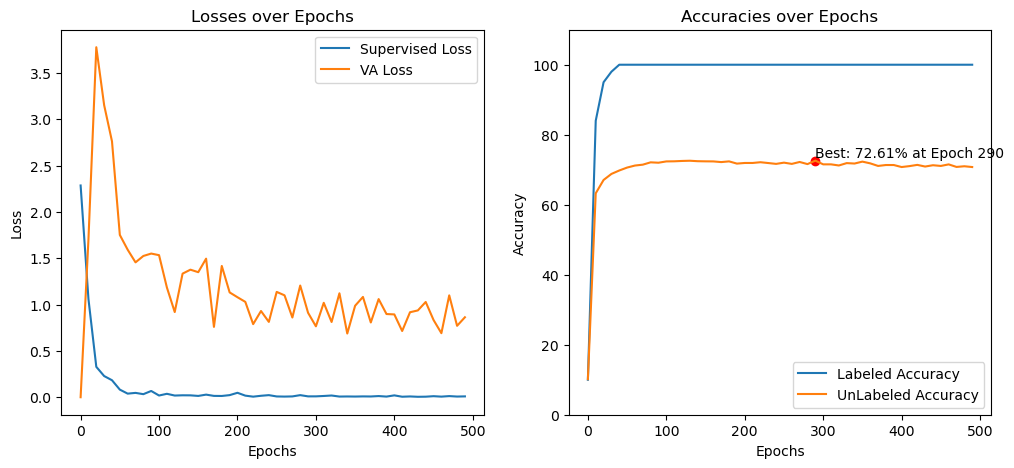

In [41]:
VAT_Model_MNIST = MnistNet()

trainAndPlot(
    model = VAT_Model_MNIST,
    labeled_loader=labeled_dataloaderMnist,
    unlabeled_loader=unlabeled_dataloaderMnist,
    b_alpha=0.1,
    num_epochs=500,
    readingAtEpoch=10,
    lr = 0.02,
    xi=1e-4,
    epsilon=0.03,
    num_power_iterations=2
)

### Two Moons Dataset

In [56]:
selected_samples = np.load('./Saved_Data/labeled_dataset_TwoMoons.npy')

remaining_samples = np.load('./Saved_Data/unlabeled_dataset_TwoMoons.npy')

# Converting the selected samples and remaining samples into PyTorch tensors
selected_samples_tensor = torch.tensor(selected_samples, dtype=torch.float32)
remaining_samples_tensor = torch.tensor(remaining_samples, dtype=torch.float32)

# Extracting features and labels for both datasets
features_selected = selected_samples_tensor[:, :2]
labels_selected = selected_samples_tensor[:, 2].long()  # converting labels to long for classification

features_remaining = remaining_samples_tensor[:, :2]
labels_remaining = remaining_samples_tensor[:, 2].long()

# Creating TensorDatasets
selected_dataset = TensorDataset(features_selected, labels_selected)
remaining_dataset = TensorDataset(features_remaining, labels_remaining)

# Creating DataLoaders
labeled_dataloaderTM = DataLoader(selected_dataset, batch_size=1)  # small batch size for the small dataset
unlabeled_dataloaderTM = DataLoader(remaining_dataset, batch_size=5)  # larger batch size for the larger dataset

In [57]:
class TwoMoonsNet(nn.Module):

    def __init__(self):

        super(TwoMoonsNet,self).__init__()

        self.fullyConnectedLayer = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10,2)
        )

    def forward(self, input):

        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

Epoch 0: Supervised Loss: 0.6678487658500671, VAT Loss: 1.1920929132713809e-08, UnLabeled Accuracy: 51.54639175257732
Epoch 1: Supervised Loss: 0.6720389723777771, VAT Loss: 5.9604645663569045e-09, UnLabeled Accuracy: 52.577319587628864
Epoch 2: Supervised Loss: 0.6740084886550903, VAT Loss: -1.7881394143159923e-08, UnLabeled Accuracy: 53.09278350515464
Epoch 3: Supervised Loss: 0.675153374671936, VAT Loss: 5.9604645663569045e-09, UnLabeled Accuracy: 55.154639175257735
Epoch 4: Supervised Loss: 0.6759205460548401, VAT Loss: 1.7881394143159923e-08, UnLabeled Accuracy: 55.670103092783506
Epoch 5: Supervised Loss: 0.6765006184577942, VAT Loss: 1.7881394143159923e-08, UnLabeled Accuracy: 56.18556701030928
Epoch 6: Supervised Loss: 0.6769863963127136, VAT Loss: 2.9802322387695312e-08, UnLabeled Accuracy: 57.7319587628866
Epoch 7: Supervised Loss: 0.6774253249168396, VAT Loss: 0.0, UnLabeled Accuracy: 57.7319587628866
Epoch 8: Supervised Loss: 0.677842915058136, VAT Loss: -1.7881394143159923

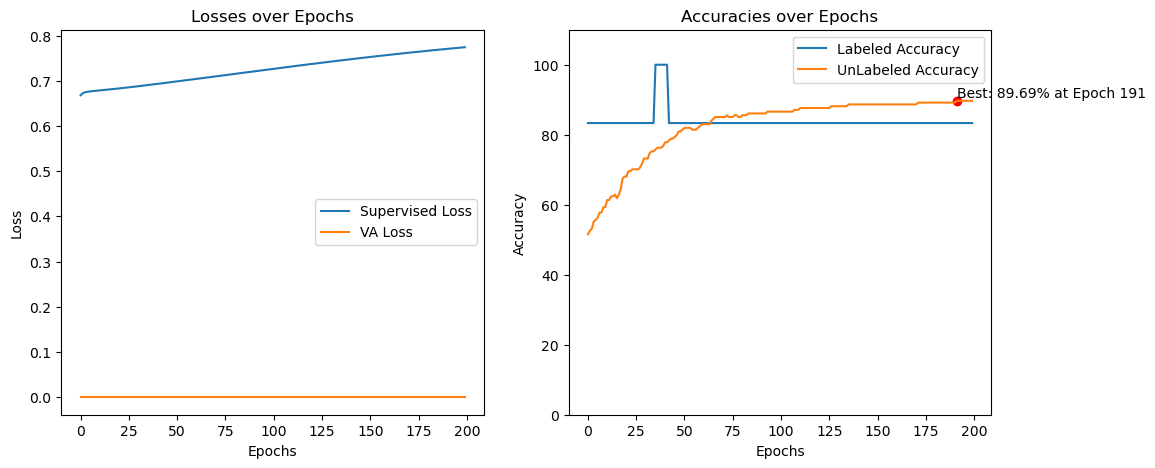

In [58]:
VAT_Model_TwoMoons = TwoMoonsNet()

trainAndPlot(
    model=VAT_Model_TwoMoons,
    labeled_loader=labeled_dataloaderTM,
    unlabeled_loader=unlabeled_dataloaderTM,
    b_alpha=1,
    num_epochs=200,
    readingAtEpoch=1,
    lr=0.001,
    xi=1e-6,
    epsilon=0.01,
    num_power_iterations=2
)

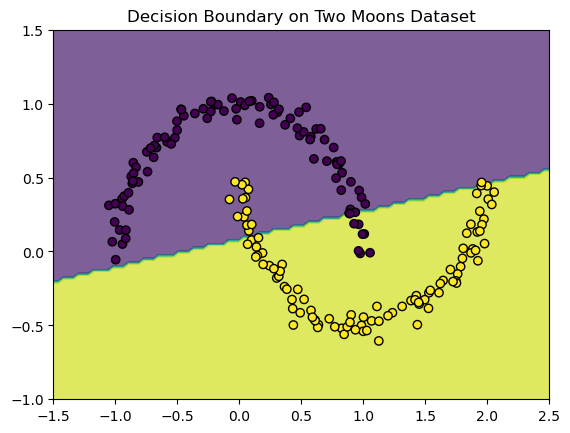

In [59]:
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

VAT_Model_TwoMoons.eval()
with torch.no_grad():
    predictions = VAT_Model_TwoMoons(grid_tensor)
    classes = torch.argmax(predictions, dim=1).numpy().reshape(xx.shape)

plt.contourf(xx, yy, classes, alpha=0.7)
plt.scatter(selected_samples[:, 0], selected_samples[:, 1], c=selected_samples[:, 2], edgecolor='k')
plt.scatter(remaining_samples[:, 0], remaining_samples[:, 1], c=remaining_samples[:, 2], edgecolor='k')
plt.title("Decision Boundary on Two Moons Dataset")
plt.show()